In [1]:
from pathlib import Path
from pprint import pp

import folium
import matplotlib.pyplot as plt
import rasterio
import numpy as np

from utils import *
from constants import *

coords = get_coords(BAND_META_PATH)

coords

{'center': Point(23.608492, 72.234425, 0.0),
 'upper_left': Point(24.188497, 71.352555, 0.0),
 'upper_right': Point(24.438392, 72.837366, 0.0),
 'lower_left': Point(22.769538, 71.647387, 0.0),
 'lower_right': Point(23.018946, 73.108987, 0.0)}

In [2]:
ul, ur, lr, ll = coords['upper_left'], coords['upper_right'], coords['lower_right'], coords['lower_left']
center = coords['center']
locations = [
    [ul.latitude, ul.longitude],
    [ur.latitude, ur.longitude],
    [lr.latitude, lr.longitude],
    [ll.latitude, ll.longitude],
    [ul.latitude, ul.longitude]
]

m = folium.Map(location=[center.latitude, center.longitude], zoom_start=9, zoom_control=False, scrollWheelZoom=False, dragging=False)

kw = {
    "color": "blue",
    "line_cap": "round",
    "fill": False,
    "weight": 5,
}

folium.Polygon(
    locations=locations,
    line_join="mitter",
    dash_array="5, 10",
    **kw
).add_to(m)

folium.Marker(
    location=[center.latitude, center.longitude],
    popup="This is the center!",
    tooltip="This is center",
    icon=folium.Icon(icon="cloud", color="red")
).add_to(m)

m

In [3]:
user_point = Point(23.2156, 72.6369)

bbox = get_bounding_box_coordinates(user_point, 25)

print(bbox)

{'upper_left': Point(23.441144715539558, 72.39224879951736, 0.0), 'lower_right': Point(22.98966947961121, 72.88073038697917, 0.0)}


In [4]:
ul, lr = bbox['upper_left'], bbox['lower_right']
bounds = [
    [ul.latitude, ul.longitude],
    [lr.latitude, lr.longitude]
]

kw = {
    "color": "red",
    "line_cap": "round",
    "fill": True,
    "fill_color": "red",
    "weight": 5,
}

folium.Rectangle(
    bounds=bounds,
    line_join="mitter",
    popup="bbox",
    **kw
).add_to(m)

folium.Marker(
    location=[user_point.latitude, user_point.longitude],
    popup="User Point",
    tooltip="User Point",
    icon=folium.Icon(color='green', icon='user')
).add_to(m)

m


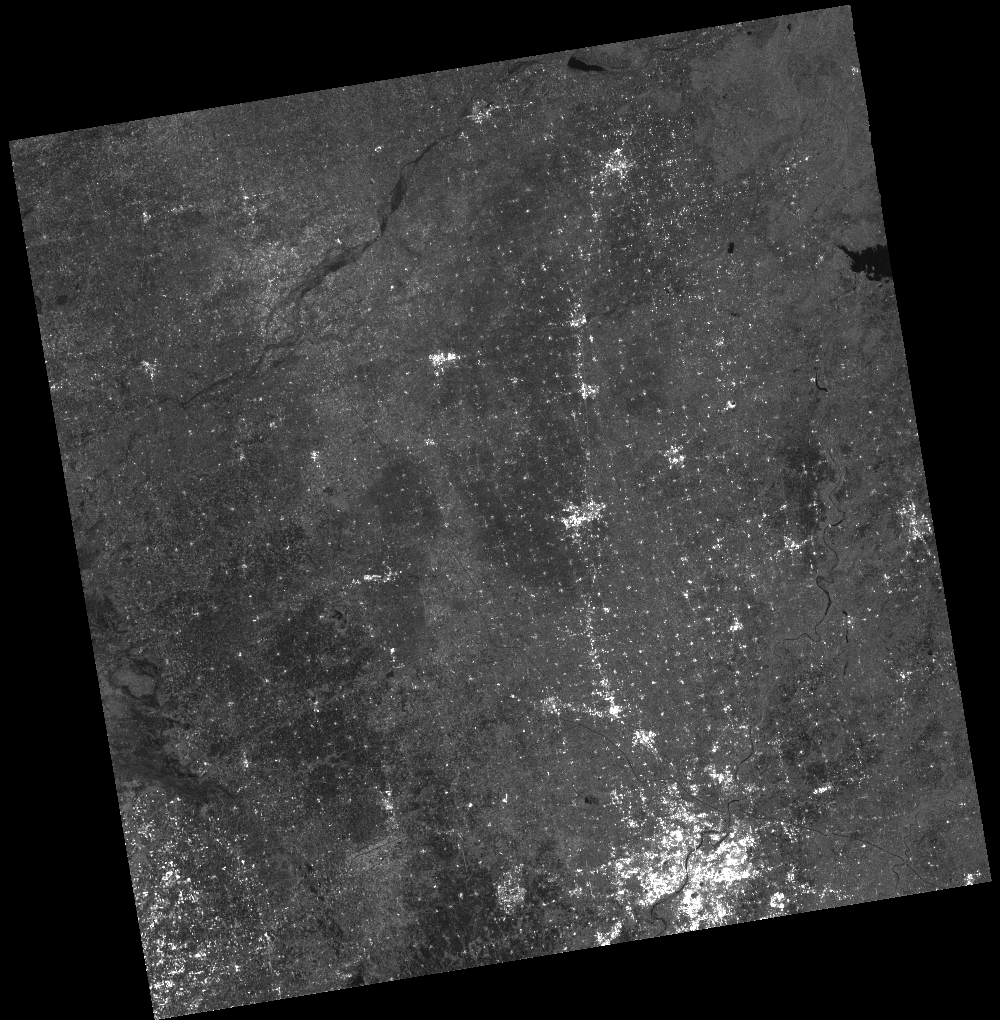

In [5]:
import folium.raster_layers

latitudes = [coord.latitude for direction, coord in coords.items() if direction != 'center']
longitudes = [coord.longitude for direction, coord in coords.items() if direction != 'center']

south = min(latitudes)
north = max(latitudes)
west = min(longitudes)
east = max(longitudes)

bounds = [[south, west], [north, east]]

img = folium.raster_layers.ImageOverlay(
    name="SAR Representation",
    image=str(IMG_PATH),
    bounds=bounds,
    interactive=False,
    opacity=0.5
).add_to(m)

m


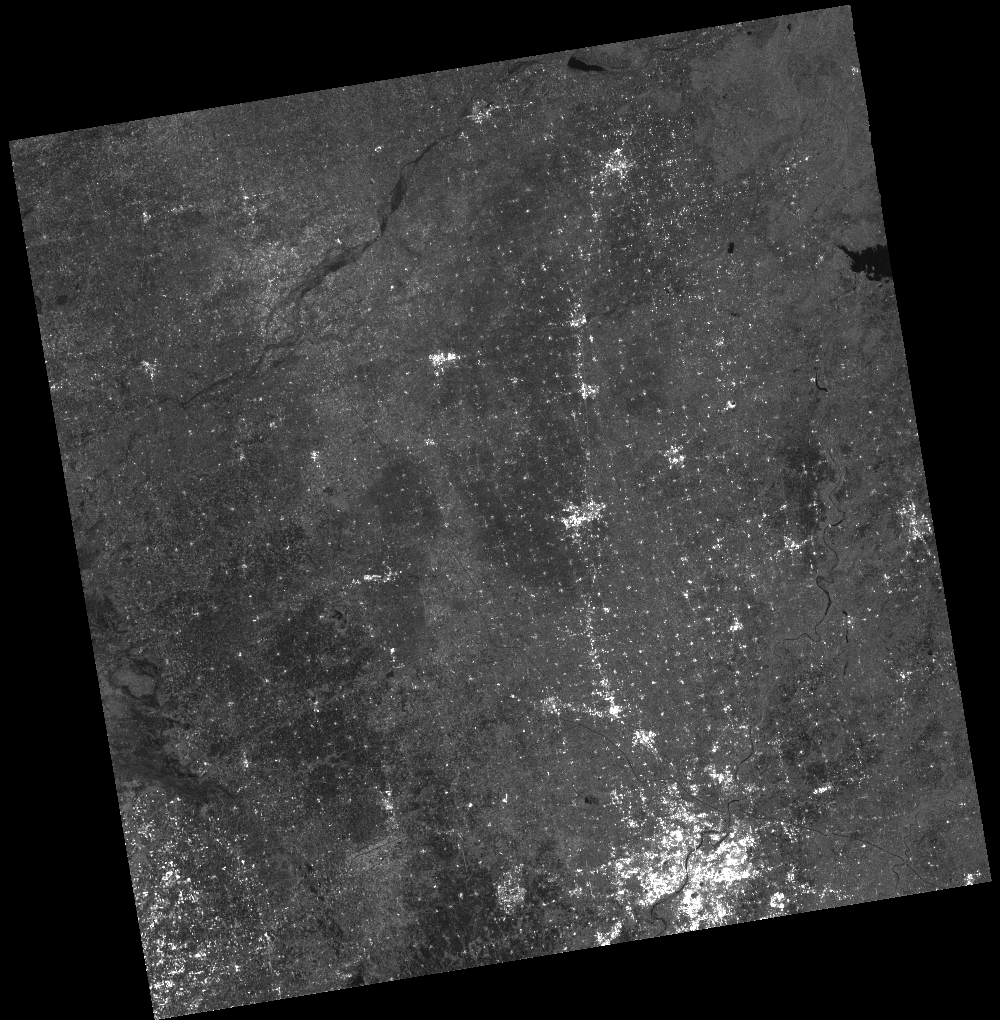

In [6]:
from sar_processing import get_latlon_from_raster

lat, lon = get_latlon_from_raster(HH_PATH)
sample_size = 10000

lat_flat = lat.flatten()
lon_flat = lon.flatten()

# Filter out any NaN values
valid_mask = (~np.isnan(lat_flat)) & (~np.isnan(lon_flat))
lat_valid = lat_flat[valid_mask]
lon_valid = lon_flat[valid_mask]

# Random sampling
indices = np.random.choice(len(lat_valid), size=min(sample_size, len(lat_valid)), replace=False)
sample_lats = lat_valid[indices]
sample_lons = lon_valid[indices]

for la, lo in zip(sample_lats, sample_lons):
    folium.CircleMarker(location=[la, lo], radius=1, color='blue', fill=True, fill_opacity=0.6).add_to(m)

m